In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt
import time 
import cv2 

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
#from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
#parameters of processing
frequency = 30 #Hz
# bag_file_name = 'data/dataset_3_ECOFLEX20.bag'
bag_file_name = '/home/kucarst3-dlws/Desktop/HALWANY/dataset_3_ECOFLEX20.bag'

h5_file_name = 'YA_dataset_1_new.hdf5'
time_window_size = 6
examples_per_edge = 1

In [3]:
pwd

'/home/kucarst3-dlws/Desktop/HALWANY/halwanyfiles'

In [4]:
# bag_file = rosbag.Bag(bag_file_name)


In [5]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

contact_case_updated = []
contact_case_updated_ts = []


#generate labels
# possible_angle = [0.075, 0.15]#[0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)


65
[[0, 0, 0], [0.01234134148078231, 0.012341341480782309, 0], [0.02468268296156462, 0.024682682961564617, 0], [0.03702402451305761, 0.037024024513057606, 0], [0.053033008588991064, 0.05303300858899106, 0], [0.06717514421272203, 0.06717514421272201, 0], [0.08131727983645297, 0.08131727983645295, 0], [0.09545941546018392, 0.09545941546018391, 0], [0.10606601717798213, 0.10606601717798211, 0], [1.0687059397353753e-18, 0.0174532925, 0], [2.1374118794707506e-18, 0.034906585, 0], [3.2061178253293598e-18, 0.0523598776, 0], [4.592425496802574e-18, 0.075, 0], [5.817072295949928e-18, 0.095, 0], [7.04171909509728e-18, 0.115, 0], [8.266365894244634e-18, 0.135, 0], [9.184850993605149e-18, 0.15, 0], [-0.012341341480782309, 0.01234134148078231, 0], [-0.024682682961564617, 0.02468268296156462, 0], [-0.037024024513057606, 0.03702402451305761, 0], [-0.05303300858899106, 0.053033008588991064, 0], [-0.06717514421272201, 0.06717514421272203, 0], [-0.08131727983645295, 0.08131727983645297, 0], [-0.09545941

In [6]:
# def filter_events_by_time(events, time_of_contact):
#         time_period = 0.3 #sec
#         end_remove_idx = 0
#         end_time = events[-1][2]#time_of_contact + time_period # time of the last event in the list
#         # print("end_time: ", end_time)
#         # print("start_time: ", events[0][2])
        
#         for i in range(0, len(events)):
#             # print(end_time - events[i][2])
#             print(end_time - events[i][2] < time_period)
#             if end_time - events[i][2] < time_period:
#                 break            
#             end_remove_idx = i  

#         events = events[end_remove_idx:]
#         #print("length: ", len(events))
#         return events

In [7]:
def filter_events_by_time(events, time_of_contact, time_period = 0.3e9, threshold=20000):
    event_time = np.array([events[i][2] for i in range(np.shape(events)[0])])
    event_in_time_idx = np.where((event_time > (time_of_contact - time_period)) * (event_time < time_of_contact))[0]
    print(len(event_in_time_idx))
    if len(event_in_time_idx) < threshold:
        return False, []
    else:
        print(event_in_time_idx)
        output_events = np.array(events)[event_in_time_idx,:]
        return True,output_events

In [8]:
# def check_contact(events):
#         contact_threshold = 10000 # no. of events 
#         #print("length: ",len(self.new_events_list))
#         if len(events) > contact_threshold:
#             contact_status = True
#         else:
#             contact_status =  False
        
#         return contact_status

In [9]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
        event_topic = True    
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

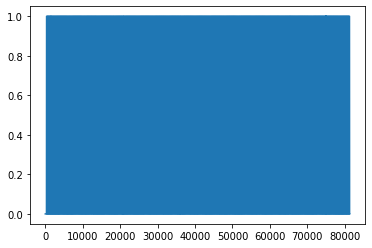

In [10]:
plt.plot(contact_status)

In [11]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

In [12]:
contact_case_int

array([0., 0., 0., ..., 0., 0., 0.])

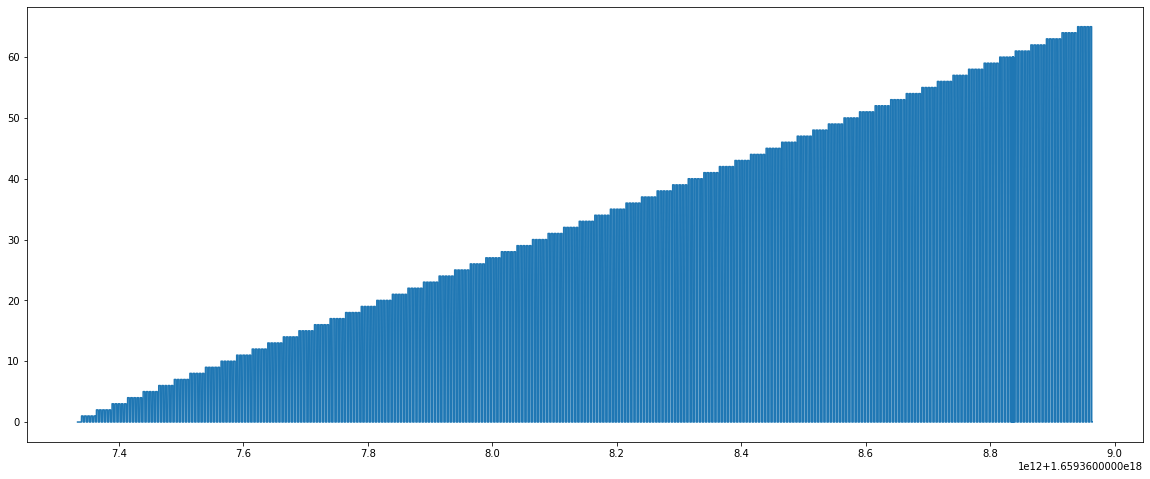

48903


In [13]:
plt.figure(figsize=(20,8))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [14]:
print((contact_case_ts_int[101] - contact_case_ts_int[100])/1e9)

0.033333333


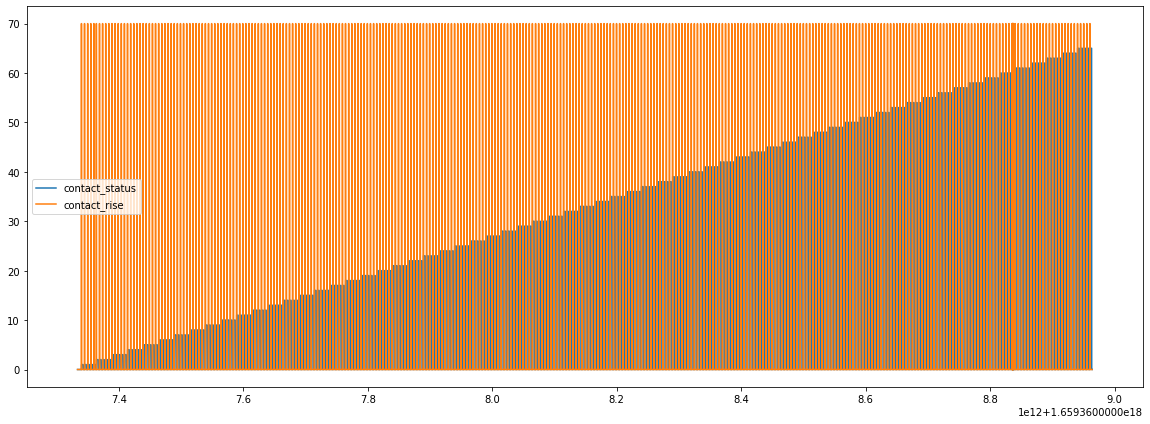

In [44]:
from scipy import signal
#find the rising peak
# contact_peaks_idx, contact_peak_magnitude = signal.find_peaks(contact_case_int, height=0.4, distance=30)
contact_case_diff_int = np.diff(contact_case_int)
contact_case_diff_int = np.insert(contact_case_diff_int, 0, 0)
contact_rise_idx = np.where(contact_case_diff_int > 0.4)[0]

contact_rise_int = [0 for i in range(len(contact_case_int))]
for index in contact_rise_idx:
    contact_rise_int[index] = 70


plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.plot(contact_case_ts_int, contact_rise_int)
plt.legend(['contact_status', 'contact_rise'])
plt.show()

In [31]:
def generateFrames(event_list, time_steps, im_height=260, im_width=346, im_channel=3, time_window=None):
        event_iterator = 0
        channel = 0
        x = [0, 0, 0]
        event_image = np.zeros((im_height, im_width, im_channel), dtype=np.float32)
        for ts in time_steps:
            
            for i in range(event_iterator, len(event_list)):
                event_iterator = i + 1
                event = np.copy(event_list[i]) #[x, y, ts, polarity]
                if (time_window==None) or (event[2] > ts - time_window):
                    if event[2] > ts:
                        event_image[201, 154, 0] = 0
                        channel = channel + 1
                        #print("cahnnel = ", channel)
                        break
                    else:
                        # print("ha")
                        x[channel] = x[channel] + 1
                        if event[3] > 0:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] + 1.0
                        else:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] - 1.0             
        
        return event_image

In [32]:
def cropFrames(image, circle_center=(173, 130), circle_rad=100, im_height=260, im_width=346, im_channels=3):
        mask = np.zeros((im_height, im_width, im_channels), dtype=np.float32)            
        cv2.circle(mask, circle_center, circle_rad, [1]*im_channels, -1, 8, 0)
        cropped_image = np.multiply(mask, image)

        return cropped_image

In [33]:
contact_case_int

array([0., 0., 0., ..., 0., 0., 0.])

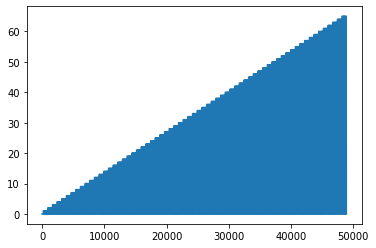

In [34]:
plt.plot(contact_case_int)

In [35]:

label_contact_case = np.array(contact_case_int)[contact_rise_idx+1]
print(label_contact_case)

[ 1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 11. 11. 11. 11.
 11. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 15. 15.
 15. 15. 15. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 19. 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 22. 22. 22.
 22. 22. 23. 23. 23. 23. 23. 24. 24. 24. 24. 24. 25. 25. 25. 25. 25. 26.
 26. 26. 26. 26. 27. 27. 27. 27. 27. 28. 28. 28. 28. 28. 29. 29. 29. 29.
 29. 30. 30. 30. 30. 30. 31. 31. 31. 31. 31. 32. 32. 32. 32. 32. 33. 33.
 33. 33. 33. 34. 34. 34. 34. 34. 35. 35. 35. 35. 35. 36. 36. 36. 36. 36.
 37. 37. 37. 37. 37. 38. 38. 38. 38. 38. 39. 39. 39. 39. 39. 40. 40. 40.
 40. 40. 41. 41. 41. 41. 41. 42. 42. 42. 42. 42. 43. 43. 43. 43. 43. 44.
 44. 44. 44. 44. 45. 45. 45. 45. 45. 46. 46. 46. 46. 46. 47. 47. 47. 47.
 47. 48. 48. 48. 48. 48. 49. 49. 49. 49. 49. 50. 50

In [40]:
label_contact_case_index=label_contact_case==0.
label_contact_case[label_contact_case_index]=60.0
label_contact_case

array([ 1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
        3.,  3.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  6.,
        6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,
        8.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 11., 11.,
       11., 11., 11., 12., 12., 12., 12., 12., 13., 13., 13., 13., 13.,
       14., 14., 14., 14., 14., 15., 15., 15., 15., 15., 16., 16., 16.,
       16., 16., 17., 17., 17., 17., 17., 18., 18., 18., 18., 18., 19.,
       19., 19., 19., 19., 20., 20., 20., 20., 20., 21., 21., 21., 21.,
       21., 22., 22., 22., 22., 22., 23., 23., 23., 23., 23., 24., 24.,
       24., 24., 24., 25., 25., 25., 25., 25., 26., 26., 26., 26., 26.,
       27., 27., 27., 27., 27., 28., 28., 28., 28., 28., 29., 29., 29.,
       29., 29., 30., 30., 30., 30., 30., 31., 31., 31., 31., 31., 32.,
       32., 32., 32., 32., 33., 33., 33., 33., 33., 34., 34., 34., 34.,
       34., 35., 35., 35., 35., 35., 36., 36., 36., 36., 36., 37

In [21]:

# hf = h5py.File("trial.hdf5", 'w')
# ii = 0
# label_contact_case = []
# for i in contact_rise_idx:
#     label_contact_case.append(np.array(contact_case_int)[i+1])
#     print(np.array(contact_case_int)[i+1])
#     print(label_contact_case)
#     if ii == 0:
#         hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None, ))
#     else:
#         hf['contact_status'].resize(len(hf['contact_status']) + len(label_contact_case), axis=0)
#         hf["contact_status"][-len(label_contact_case):] = label_contact_case
#     ii = ii +1
# print(hf['contact_status'].shape)
# hf.close()

# print(len(hf['contact_status']))
# hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
# print(len(hf['contact_status']))
# hf["contact_status"][-len(label_contact_case):] = label_contact_case
# print(len(hf['contact_status']))

In [22]:
# hf = h5py.File(h5_file_name, 'w')
# #find events that satisfy time
# label_contact_case = []
# i=0
# for status_index in contact_rise_idx:
#     #event_frames_list = []
#     for j in range(-7, 8):
#         time_step = contact_case_ts_int[ status_index + j ]
#         detect, event_array = filter_events_by_time(events, time_step)
#         if detect:
#             frame_time_steps = [time_step-0.2e9, time_step-0.1e9, time_step]
#             event_frame = generateFrames(event_array, frame_time_steps)
#             cropped_image = cropFrames(event_frame)
#             #event_frames_list.append(cropped_image)
#             label_contact_case = np.array(contact_case_int)[status_index+1]
#             if i==0:
#                 hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None,))
#                 hf.create_dataset('event_images', data=cropped_image, maxshape=(None,None, None, None))
#             else:
#                 hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
#                 hf["contact_status"][-1] = label_contact_case
#                 hf['event_images'].resize(len(hf['event_images']) + 1, axis=0)
#                 hf["event_images"][-1] = cropped_image 
#             break

#     i = i + 1
    
    

# hf.close()

In [41]:
contact_rise_idx

array([  188,   336,   488,   637,   787,   907,  1058,  1207,  1357,
        1508,  1659,  1807,  1959,  2110,  2259,  2408,  2559,  2709,
        2860,  3010,  3158,  3309,  3461,  3611,  3759,  3909,  4061,
        4212,  4361,  4511,  4660,  4811,  4961,  5110,  5261,  5411,
        5561,  5711,  5863,  6012,  6161,  6312,  6462,  6612,  6761,
        6913,  7063,  7213,  7364,  7512,  7665,  7814,  7963,  8113,
        8264,  8414,  8564,  8714,  8864,  9014,  9165,  9315,  9465,
        9614,  9764,  9915, 10065, 10216, 10365, 10515, 10666, 10816,
       10966, 11118, 11266, 11416, 11567, 11715, 11866, 12016, 12168,
       12316, 12469, 12617, 12768, 12916, 13068, 13217, 13368, 13518,
       13670, 13818, 13969, 14119, 14269, 14419, 14569, 14719, 14869,
       15019, 15169, 15319, 15469, 15619, 15771, 15920, 16070, 16220,
       16370, 16521, 16670, 16823, 16970, 17120, 17270, 17422, 17571,
       17722, 17872, 18022, 18173, 18324, 18472, 18622, 18771, 18925,
       19071, 19222,

In [42]:
print(len(label_contact_case))
print(len(contact_rise_idx))


339
339


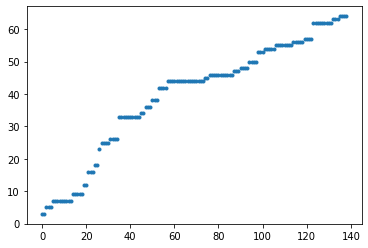

In [49]:
plt.plot(label_contact_case ,'.')

In [47]:
# hf = h5py.File(h5_file_name+"ya22;2", 'w')
#find events that satisfy time
label_contact_case = []
YA_eventseq=[]
i=0
for status_index in contact_rise_idx:
    print("status_index", status_index)
    event_frames_list = []
    for j in range(-7, 8):
        print("j", j)
        time_step = contact_case_ts_int[ status_index + j ]
        detect, event_array = filter_events_by_time(events, time_step)
#         print( "detect, event_array", detect, event_array)
        if detect:
            frame_time_steps = [time_step-0.05e9, time_step-0.025e9, time_step]
            YA_eventseq.append(event_array)
            
            #event arrays
            #
            
#             event_frame = generateFrames(event_array, frame_time_steps)
#             print("event_array", len(event_array))
#             print("2", event_array)
            
#             cropped_image = cropFrames(event_frame)
#             event_frames_list.append(cropped_image)
            label_contact_case.append(np.array(contact_case_int)[status_index+1])
#             if not ('contact_status' in hf.keys()):
#                 hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None,))
#                 hf.create_dataset('event_images', data=event_frames_list, maxshape=(None,None, None, None))
#             else:
#                 hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
#                 hf["contact_status"][-len(label_contact_case):] = label_contact_case
#                 hf['event_images'].resize(len(hf['event_images']) + len(event_frames_list), axis=0)
#                 hf["event_images"][-len(event_frames_list):] = event_frames_list 
#             break

    i = i + 1
    
# hf.close()

status_index 188
j -7
125
j -6
134
j -5
171
j -4
171
j -3
182
j -2
169
j -1
363
j 0
2023
j 1
3274
j 2
3738
j 3
4471
j 4
4522
j 5
4549
j 6
4604
j 7
4611
status_index 336
j -7
96
j -6
102
j -5
90
j -4
105
j -3
112
j -2
142
j -1
151
j 0
214
j 1
3908
j 2
8369
j 3
11905
j 4
13580
j 5
14387
j 6
15369
j 7
15853
status_index 488
j -7
124
j -6
136
j -5
146
j -4
165
j -3
163
j -2
150
j -1
151
j 0
489
j 1
1154
j 2
1329
j 3
1722
j 4
1816
j 5
1819
j 6
1869
j 7
1879
status_index 637
j -7
118
j -6
125
j -5
127
j -4
142
j -3
134
j -2
129
j -1
122
j 0
128
j 1
657
j 2
1697
j 3
1964
j 4
2507
j 5
2785
j 6
2820
j 7
2874
status_index 787
j -7
149
j -6
143
j -5
124
j -4
131
j -3
136
j -2
147
j -1
163
j 0
954
j 1
3946
j 2
6559
j 3
7711
j 4
8381
j 5
8865
j 6
9088
j 7
9137
status_index 907
j -7
127
j -6
121
j -5
119
j -4
110
j -3
120
j -2
113
j -1
119
j 0
2164
j 1
6345
j 2
10435
j 3
13578
j 4
15038
j 5
16405
j 6
16803
j 7
16973
status_index 1058
j -7
113
j -6
121
j -5
121
j -4
123
j -3
122
j -2
130
j -1
127
j 0

In [48]:
print(len(YA_eventseq))
print(len(label_contact_case))

139
139


In [ ]:
plt.plot(YA_eventseq[2][:,2]-YA_eventseq[2][0,2])
max(YA_eventseq[0][:,2])

In [ ]:
# import numpy
# nb_events=15000

# YA_eventseq2=[]
# for i in range(0,len(YA_eventseq)):
# #     print(i)
#     YA_eventseq_v1=numpy.stack(YA_eventseq[i])
#     YA_eventseq2.append(YA_eventseq_v1[:nb_events])
# YA_eventseq2_v2=numpy.stack(YA_eventseq2)


In [50]:
import numpy
nb_events=5000

YA_eventseq2=[]
YA_eventseq_v11=[]
for i in range(0,len(YA_eventseq)):
#     print(i)
    YA_eventseq_v1=numpy.stack(YA_eventseq[i])
    nb_events_id=[(YA_eventseq_v1[:,2]-YA_eventseq_v1[0,2])<30e8]
    print(nb_events_id)
#     plt.plot(nb_events_id)
#     print(len(YA_eventseq_v1),len(nb_events_id[0] ))
    YA_eventseq_v11=YA_eventseq_v1[nb_events_id][-nb_events:]
        
    YA_eventseq2.append(YA_eventseq_v11)
YA_eventseq2_v2=numpy.stack(YA_eventseq2)

[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]


/home/kucarst3-dlws/anaconda3/envs/HAL/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ...,  True,  True,  True])]
[array([ True,  True,  True, ..

In [51]:
len(YA_eventseq)

139

In [ ]:
# max((YA_eventseq2_v2[b][:,2]-YA_eventseq2_v2[b][0,2]))<1e8

In [ ]:
# len(YA_eventseq2_v2[1])

In [ ]:
b=20
plt.plot(YA_eventseq2[b][:,2]-YA_eventseq2[b][0,2])

In [ ]:

YA_eventseq2_v2[0][:,3]

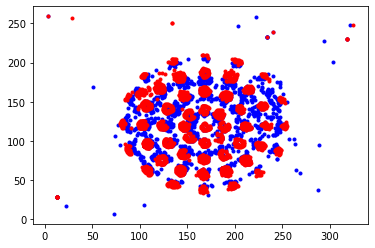

In [53]:
b=138
plt.plot(YA_eventseq2[b][:,0][YA_eventseq2[b][:,3]==1],YA_eventseq2[b][:,1][YA_eventseq2[b][:,3]==1], 'b.')
plt.plot(YA_eventseq2[b][:,0][YA_eventseq2[b][:,3]==0],YA_eventseq2[b][:,1][YA_eventseq2[b][:,3]==0], 'r.')


In [54]:
len(YA_eventseq2_v2)

139

In [55]:
label_contact_case

[3.0,
 3.0,
 5.0,
 5.0,
 5.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 12.0,
 12.0,
 16.0,
 16.0,
 16.0,
 18.0,
 18.0,
 23.0,
 25.0,
 25.0,
 25.0,
 25.0,
 26.0,
 26.0,
 26.0,
 26.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 34.0,
 34.0,
 36.0,
 36.0,
 36.0,
 38.0,
 38.0,
 38.0,
 42.0,
 42.0,
 42.0,
 42.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 45.0,
 45.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 47.0,
 47.0,
 47.0,
 48.0,
 48.0,
 48.0,
 48.0,
 50.0,
 50.0,
 50.0,
 50.0,
 53.0,
 53.0,
 53.0,
 54.0,
 54.0,
 54.0,
 54.0,
 54.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 57.0,
 57.0,
 57.0,
 57.0,
 62.0,
 62.0,
 62.0,
 62.0,
 62.0,
 62.0,
 62.0,
 62.0,
 62.0,
 63.0,
 63.0,
 63.0,
 64.0,
 64.0,
 64.0,
 64.0]

In [56]:
T_ya=numpy.zeros(( len(label_contact_case),2))

In [57]:
T_ya

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [58]:
all_indexes1 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 1.0]
all_indexes2 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 2.0]
all_indexes3 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 3.0]
all_indexes4 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 4.0]
all_indexes5 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 5.0]
all_indexes6 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 6.0]
all_indexes7 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 7.0]
all_indexes8 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 8.0]
all_indexes9 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 9.0]
all_indexes10 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 10.0]
all_indexes11 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 11.0]
all_indexes12 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 12.0]
all_indexes13 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 13.0]
all_indexes14 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 14.0]
all_indexes15 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 15.0]
all_indexes16 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 16.0]
all_indexes17 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 17.0]
all_indexes18 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 18.0]
all_indexes19 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 19.0]
all_indexes20 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 20.0]
all_indexes21 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 21.0]
all_indexes22 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 22.0]
all_indexes23 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 23.0]
all_indexes24 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 24.0]
all_indexes25 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 25.0]
all_indexes26 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 26.0]
all_indexes27 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 27.0]
all_indexes28 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 28.0]
all_indexes29 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 29.0]
all_indexes30 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 30.0]
all_indexes31 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 31.0]
all_indexes32 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 32.0]
all_indexes33 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 33.0]
all_indexes34 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 34.0]
all_indexes35 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 35.0]
all_indexes36 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 36.0]
all_indexes37 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 37.0]
all_indexes38 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 38.0]
all_indexes39 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 39.0]
all_indexes40 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 40.0]
all_indexes41 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 41.0]
all_indexes42 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 42.0]
all_indexes43 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 43.0]
all_indexes44 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 44.0]
all_indexes45 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 45.0]
all_indexes46 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 46.0]
all_indexes47 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 47.0]
all_indexes48 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 48.0]
all_indexes49 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 49.0]
all_indexes50 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 50.0]
all_indexes51 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 51.0]
all_indexes52 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 52.0]
all_indexes53 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 53.0]
all_indexes54 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 54.0]
all_indexes55 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 55.0]
all_indexes56 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 56.0]
all_indexes57 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 57.0]
all_indexes58 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 58.0]
all_indexes59 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 59.0]
all_indexes60 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 60.0]
all_indexes61 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 61.0]
all_indexes62 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 62.0]
all_indexes63 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 63.0]
all_indexes64 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 64.0]
all_indexes65 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 65.0]
all_indexes66 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 66.0]
all_indexes67 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 67.0]
all_indexes68 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 68.0]
all_indexes69 = [a for a in range(len(label_contact_case)) if label_contact_case[a] == 69.0]


In [ ]:
# for i in range(0,len(all_indexes1)):
#     T_ya[all_indexes1[i]]=[0, 0]
    
    
# for i in range(0,len(all_indexes2)):
#     T_ya[all_indexes2[i]]=[0.053033008588991064, 0.05303300858899106]

# for i in range(0,len(all_indexes3)):
#     T_ya[all_indexes3[i]]=[0.10606601717798213, 0.10606601717798211]


# for i in range(0,len(all_indexes4)):
#     T_ya[all_indexes4[i]]=[4.592425496802574e-18, 0.075]

# for i in range(0,len(all_indexes5)):
#     T_ya[all_indexes5[i]]=[9.184850993605149e-18, 0.15]


# for i in range(0,len(all_indexes6)):
#     T_ya[all_indexes6[i]]=[-0.05303300858899106, 0.053033008588991064]

# for i in range(0,len(all_indexes7)):
#     T_ya[all_indexes7[i]]=[-0.10606601717798211, 0.10606601717798213]


# for i in range(0,len(all_indexes8)):
#     T_ya[all_indexes8[i]]=[-0.075, 9.184850993605149e-18]

# for i in range(0,len(all_indexes9)):
#     T_ya[all_indexes9[i]]=[-0.15, 1.8369701987210297e-17]

# for i in range(0,len(all_indexes10)):
#     T_ya[all_indexes10[i]]=[-0.05303300858899108, -0.05303300858899106]


# for i in range(0,len(all_indexes11)):
#     T_ya[all_indexes11[i]]=[-0.10606601717798216, -0.10606601717798211]


# for i in range(0,len(all_indexes12)):
#     T_ya[all_indexes12[i]]=[-1.3777276490407722e-17, -0.075]

# for i in range(0,len(all_indexes13)):
#     T_ya[all_indexes13[i]]=[-2.7554552980815445e-17, -0.15]


# for i in range(0,len(all_indexes14)):
#     T_ya[all_indexes14[i]]=[0.05303300858899105, -0.05303300858899108]


# for i in range(0,len(all_indexes15)):
#     T_ya[all_indexes15[i]]=[0.1060660171779821, -0.10606601717798216]

# for i in range(0,len(all_indexes16)):
#     T_ya[all_indexes16[i]]= [0.075, -1.8369701987210297e-17]


# for i in range(0,len(all_indexes17)):
#     T_ya[all_indexes17[i]]=[0.15, -3.6739403974420595e-17]

In [59]:


 
for i in range(0,len(all_indexes1)):
    T_ya[all_indexes1[i]]=[0, 0]



for i in range(0,len(all_indexes2)):
    T_ya[all_indexes2[i]]=[0.01234134148078231, 0.012341341480782309]

for i in range(0,len(all_indexes3)):
    T_ya[all_indexes3[i]]=[0.02468268296156462, 0.024682682961564617]



for i in range(0,len(all_indexes4)):
    T_ya[all_indexes4[i]]=[0.03702402451305761, 0.037024024513057606]




for i in range(0,len(all_indexes5)):
    T_ya[all_indexes5[i]]= [0.053033008588991064, 0.05303300858899106]


for i in range(0,len(all_indexes6)):
    T_ya[all_indexes6[i]]= [0.06717514421272203, 0.06717514421272201]



for i in range(0,len(all_indexes7)):
    T_ya[all_indexes7[i]]=[0.08131727983645297, 0.08131727983645295]

    
for i in range(0,len(all_indexes8)):
    T_ya[all_indexes8[i]]=[0.09545941546018392, 0.09545941546018391]



for i in range(0,len(all_indexes9)):
    T_ya[all_indexes9[i]]=[0.10606601717798213, 0.10606601717798211]

    
    
    



for i in range(0,len(all_indexes10)):
    T_ya[all_indexes10[i]]=[1.0687059397353753e-18, 0.0174532925]

    
for i in range(0,len(all_indexes11)):
    T_ya[all_indexes11[i]]=[2.1374118794707506e-18, 0.034906585]



for i in range(0,len(all_indexes12)):
    T_ya[all_indexes12[i]]=[3.2061178253293598e-18, 0.0523598776]


for i in range(0,len(all_indexes13)):
    T_ya[all_indexes13[i]]=[4.592425496802574e-18, 0.075]



for i in range(0,len(all_indexes14)):
    T_ya[all_indexes14[i]]=[5.817072295949928e-18, 0.095]




for i in range(0,len(all_indexes15)):
    T_ya[all_indexes15[i]]= [7.04171909509728e-18, 0.115]


for i in range(0,len(all_indexes16)):
    T_ya[all_indexes16[i]]= [8.266365894244634e-18, 0.135]



for i in range(0,len(all_indexes17)):
    T_ya[all_indexes17[i]]=[9.184850993605149e-18, 0.15]

    
for i in range(0,len(all_indexes18)):
    T_ya[all_indexes18[i]]=[-0.012341341480782309, 0.01234134148078231]



for i in range(0,len(all_indexes19)):
    T_ya[all_indexes19[i]]=[-0.024682682961564617, 0.02468268296156462]

    
    
    
    
for i in range(0,len(all_indexes20)):
    T_ya[all_indexes20[i]]=[-0.037024024513057606, 0.03702402451305761]

    
for i in range(0,len(all_indexes21)):
    T_ya[all_indexes21[i]]=[-0.05303300858899106, 0.053033008588991064]



for i in range(0,len(all_indexes22)):
    T_ya[all_indexes22[i]]=[-0.06717514421272201, 0.06717514421272203]


for i in range(0,len(all_indexes23)):
    T_ya[all_indexes23[i]]=[-0.08131727983645295, 0.0813172798364529]


for i in range(0,len(all_indexes24)):
    T_ya[all_indexes24[i]]=[-0.09545941546018391, 0.09545941546018392]




for i in range(0,len(all_indexes25)):
    T_ya[all_indexes25[i]]= [-0.10606601717798211, 0.10606601717798213]


for i in range(0,len(all_indexes26)):
    T_ya[all_indexes26[i]]= [-0.0174532925, 2.1374118794707506e-18]



for i in range(0,len(all_indexes27)):
    T_ya[all_indexes27[i]]=[-0.034906585, 4.274823758941501e-18]

    
for i in range(0,len(all_indexes28)):
    T_ya[all_indexes28[i]]=[-0.0523598776, 6.4122356506587196e-18]



for i in range(0,len(all_indexes29)):
    T_ya[all_indexes29[i]]=[-0.075, 9.184850993605149e-18]

    
    
    
for i in range(0,len(all_indexes30)):
    T_ya[all_indexes30[i]]=[-0.095, 1.1634144591899856e-17]

    
for i in range(0,len(all_indexes31)):
    T_ya[all_indexes31[i]]=[-0.115, 1.408343819019456e-17]


for i in range(0,len(all_indexes32)):
    T_ya[all_indexes32[i]]=[-0.135, 1.653273178848927e-17]


for i in range(0,len(all_indexes33)):
    T_ya[all_indexes33[i]]=[-0.15, 1.8369701987210297e-17]



for i in range(0,len(all_indexes34)):
    T_ya[all_indexes34[i]]=[-0.012341341480782312, -0.012341341480782309]




for i in range(0,len(all_indexes35)):
    T_ya[all_indexes35[i]]= [-0.024682682961564624, -0.024682682961564617]


for i in range(0,len(all_indexes36)):
    T_ya[all_indexes36[i]]= [-0.03702402451305762, -0.037024024513057606]



for i in range(0,len(all_indexes37)):
    T_ya[all_indexes37[i]]=[-0.05303300858899108, -0.05303300858899106]

    
for i in range(0,len(all_indexes38)):
    T_ya[all_indexes38[i]]=[-0.06717514421272203, -0.06717514421272201]



for i in range(0,len(all_indexes39)):
    T_ya[all_indexes39[i]]=[-0.08131727983645298, -0.08131727983645295]

    
    
    
    

for i in range(0,len(all_indexes40)):
    T_ya[all_indexes40[i]]=[-0.09545941546018394, -0.09545941546018391]

    
for i in range(0,len(all_indexes41)):
    T_ya[all_indexes41[i]]=[-0.10606601717798216, -0.10606601717798211]



for i in range(0,len(all_indexes42)):
    T_ya[all_indexes42[i]]=[-3.2061178192061255e-18, -0.0174532925]


for i in range(0,len(all_indexes43)):
    T_ya[all_indexes43[i]]=[-6.412235638412251e-18, -0.034906585]



for i in range(0,len(all_indexes44)):
    T_ya[all_indexes44[i]]=[-9.618353475988079e-18, -0.0523598776]




for i in range(0,len(all_indexes45)):
    T_ya[all_indexes45[i]]= [-1.3777276490407722e-17, -0.075]


for i in range(0,len(all_indexes46)):
    T_ya[all_indexes46[i]]= [-1.745121688784978e-17, -0.095]



for i in range(0,len(all_indexes47)):
    T_ya[all_indexes47[i]]=[-2.1125157285291842e-17, -0.115]

    
for i in range(0,len(all_indexes48)):
    T_ya[all_indexes48[i]]=[-2.4799097682733903e-17, -0.135]



for i in range(0,len(all_indexes49)):
    T_ya[all_indexes49[i]]=[-2.7554552980815445e-17, -0.15]

    
    
    
    

for i in range(0,len(all_indexes50)):
    T_ya[all_indexes50[i]]=[0.012341341480782307, -0.012341341480782312]

    
for i in range(0,len(all_indexes51)):
    T_ya[all_indexes51[i]]=[0.024682682961564614, -0.024682682961564624]



for i in range(0,len(all_indexes52)):
    T_ya[all_indexes52[i]]=[0.0370240245130576, -0.03702402451305762]


for i in range(0,len(all_indexes53)):
    T_ya[all_indexes53[i]]=[0.05303300858899105, -0.05303300858899108]



for i in range(0,len(all_indexes54)):
    T_ya[all_indexes54[i]]=[0.067175144212722, -0.06717514421272203]




for i in range(0,len(all_indexes55)):
    T_ya[all_indexes55[i]]= [0.08131727983645295, -0.08131727983645298]


for i in range(0,len(all_indexes56)):
    T_ya[all_indexes56[i]]=[0.0954594154601839, -0.09545941546018394]

for i in range(0,len(all_indexes57)):
    T_ya[all_indexes57[i]]=[0.1060660171779821, -0.10606601717798216]

    
for i in range(0,len(all_indexes58)):
    T_ya[all_indexes58[i]]=[0.0174532925, -4.274823758941501e-18]



for i in range(0,len(all_indexes59)):
    T_ya[all_indexes59[i]]=[0.034906585, -8.549647517883002e-18]

    

for i in range(0,len(all_indexes60)):
    T_ya[all_indexes60[i]]=[0.0523598776, -1.2824471301317439e-17]

    
for i in range(0,len(all_indexes61)):
    T_ya[all_indexes61[i]]=[0.075, -1.8369701987210297e-17]



for i in range(0,len(all_indexes62)):
    T_ya[all_indexes62[i]]=[0.095, -2.3268289183799712e-17]


for i in range(0,len(all_indexes63)):
    T_ya[all_indexes63[i]]=[0.115, -2.816687638038912e-17]



for i in range(0,len(all_indexes64)):
    T_ya[all_indexes64[i]]=[0.135, -3.306546357697854e-17]




for i in range(0,len(all_indexes65)):
    T_ya[all_indexes65[i]]= [0.15, -3.6739403974420595e-17]



In [60]:
T_ya

array([[ 2.46826830e-02,  2.46826830e-02],
       [ 2.46826830e-02,  2.46826830e-02],
       [ 5.30330086e-02,  5.30330086e-02],
       [ 5.30330086e-02,  5.30330086e-02],
       [ 5.30330086e-02,  5.30330086e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 8.13172798e-02,  8.13172798e-02],
       [ 1.06066017e-01,  1.06066017e-01],
       [ 1.06066017e-01,  1.06066017e-01],
       [ 1.06066017e-01,  1.06066017e-01],
       [ 1.06066017e-01,  1.06066017e-01],
       [ 1.06066017e-01,  1.06066017e-01],
       [ 3.20611783e-18,  5.23598776e-02],
       [ 3.20611783e-18,  5.23598776e-02],
       [ 8.26636589e-18,  1.35000000e-01],
       [ 8.26636589e-18,  1.35000000e-01],
       [ 8.

In [61]:
len(T_ya)

139

In [62]:
YA_eventseq2_v2_

NameError: name 'YA_eventseq2_v2_' is not defined

In [ ]:
# np.save('T_ya_v3.npy', T_ya) # save
# new_num_arr = np.load('T_ya_v3.npy') # load


# # 

In [ ]:
# np.save('YA_eventseq2_v3.npy', YA_eventseq2_v2) # save
# YA_eventseq2_v2_ = np.load('YA_eventseq2_v3.npy') # load

In [65]:
np.savez('data_Hal_in_out_newSet.npz', X=YA_eventseq2_v2, Y=T_ya)


In [64]:
len(YA_eventseq2_v2)

139

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
X1, y1 = np.arange(10).reshape((5, 2)), np.arange(5)
print(X1)
print(y1)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[0 1 2 3 4]


In [75]:
X_train, X_val, y_train, y_val = train_test_split(
...     YA_eventseq2_v2, T_ya, test_size=0.4, random_state=42)

In [76]:
X_valid, X_test, y_valid, y_test = train_test_split(
...     X_val, y_val, test_size=0.5, random_state=42)

In [79]:
np.savez('data_Hal_in_out_newSet_train.npz', X=X_train, Y=y_train)
np.savez('data_Hal_in_out_newSet_valid.npz', X=X_valid, Y=y_valid)
np.savez('data_Hal_in_out_newSet_test.npz', X=X_test, Y=y_test)


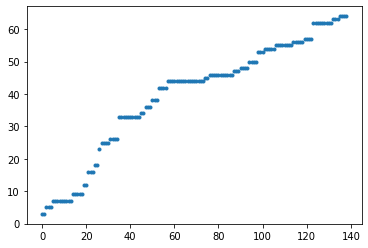

In [80]:
plt.plot(label_contact_case, '.')

In [ ]:
# hf = h5py.File(h5_file_name, 'w')
# #find events that satisfy time
# label_contact_case = []
# i=0
# for status_index in contact_rise_idx:
#     event_frames_list = []
#     for j in range(-7, 8):
#         time_step = contact_case_ts_int[ status_index + j ]
#         detect, event_array = filter_events_by_time(events, time_step)
#         if detect:
#             frame_time_steps = [time_step-0.2e9, time_step-0.1e9, time_step]
#             event_frame = generateFrames(event_array, frame_time_steps)
#             cropped_image = cropFrames(event_frame)
#             event_frames_list.append(cropped_image)
#             label_contact_case.append(np.array(contact_case_int)[status_index+1])
#             if not ('contact_status' in hf.keys()):
#                 hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None,))
#                 hf.create_dataset('event_images', data=event_frames_list, maxshape=(None,None, None, None))
#             else:
#                 hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
#                 hf["contact_status"][-len(label_contact_case):] = label_contact_case
#                 hf['event_images'].resize(len(hf['event_images']) + len(event_frames_list), axis=0)
#                 hf["event_images"][-len(event_frames_list):] = event_frames_list 
#             break

#     i = i + 1
    
# hf.close()

In [82]:
# events[0][:,2]

In [ ]:
#read dependancies

from __future__ import division
import os.path as osp

import math
import shutil
import os
import io
import time 
import csv
import sys
import random 
import glob
import pandas as pd
import networkx as nx
import numpy
import numpy as np
import matplotlib.pyplot as plt


##------------------t
import torch
from torch import nn
import torch.nn as nn 
import torch.optim as optim
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.nn import Sequential as Seq, Dropout, Linear as Lin, BatchNorm1d as BN, ReLU


import torch_scatter
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import max_pool, max_pool_x, graclus, global_mean_pool, GCNConv,  global_mean_pool, SAGEConv
from torch_geometric.nn.conv import TransformerConv
from torch_geometric.nn.pool import voxel_grid
from torch_geometric.transforms import Cartesian
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.nn.pool import radius_graph

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections.abc import Sequence
from collections import Counter
from sklearn.utils import compute_class_weight
from torch import Tensor
try:
    import torch_cluster
except ImportError:
    torch_cluster = None
import time


import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# from utils import Logger


torch.cuda.empty_cache()


In [ ]:
np.save('data.npy', num_arr) # save
new_num_arr = np.load('data.npy') # load

In [ ]:

# event_times = np.array([events[i][2] for i in range(np.shape(events)[0])])
# threshold = 10000
# plt.plot(event_times)
# plt.show()
# print(contact_case_ts_int[ contact_rise_idx[0] ])
# event_in_time_idx = np.where((event_times > (contact_case_ts_int[ contact_rise_idx[0] ] - 0.3)) * (event_times < contact_case_ts_int[ contact_rise_idx[0] ] ))
# print(len(event_in_time_idx))
# if len(event_in_time_idx) < threshold:
#     print("ok")
# else:
#     output_events = events[event_in_time_idx][:]
#     print("why")

In [ ]:
del EventPreProcess
from importlib import reload  
import EventPreProcess
reload(EventPreProcess)
from EventPreProcess import EventPreProcess

In [ ]:
#Generate frames, crop and and store in h5 file
#hf.close()
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)
# print(len(contact_case_int))
# print(contact_case_ts_int)
# desired_status = 12
# encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))#searches for the desired status
# print(encounter)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])
    #[event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])

    #[event_frames, unprocessed_events] = EventPreProcess.generateFrames_temporalROI(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    [event_frames, unprocessed_events] = EventPreProcess.generateFrames(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    
    #print("event frames shape : ", np.shape(event_frames))
    cropped_image = EventPreProcess.cropFrames(event_frames, circle_center=(170, 125), circle_rad=115)
    #print("length cropped iamges : ", len(cropped_image))
    
    #write data
    if i==0:
        hf.create_dataset('event_images', data=cropped_image, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(cropped_image), axis=0)
        hf["event_images"][-len(cropped_image):] = cropped_image 

    
    del event_frames

hf.close()

In [ ]:
# hf = h5py.File(h5_file_name, 'r+')
# desired_status = 13
# encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))#searches for the desired status
# print(encounter)
# print("time of contact = ", (hf['time_steps'][encounter]/1e9))

# original_image = hf['event_images'][encounter]
# original_contact_status = hf['contact_status'][encounter]
# rot_90_image = EventPreProcess.rotateFrames([original_image], circle_center=(170, 125), rotate_angle=90)
# rot_90_contact_status = EventPreProcess.updateContactStatus([original_contact_status], list_of_rotations, 90)

# plt.imshow(original_image[:,:,0])
# plt.show()
# print(original_contact_status)
# print(rot_90_contact_status)
# plt.imshow(rot_90_image[0])
# plt.show()
# hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['contact_status'].shape)
print(hf['event_images'].shape)
hf.close()


In [ ]:
def rotateFrames(image_list, circle_center=(173, 130), rotate_angle=90, im_height=260, im_width=346, expand_dims=False):
        
        rotated_image_list = []

        for image in image_list:
            rot_mat = cv2.getRotationMatrix2D(circle_center, rotate_angle, 1.0)
            #rotated_image = cv2.warpAffine(image[:,:,0], rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

            if expand_dims:
                rotated_image_list.append(np.expand_dims(np.copy(rotated_image), axis=2)) 
            else:
                rotated_image_list.append(np.copy(rotated_image))

        return rotated_image_list


In [ ]:
hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['contact_status_augmented'])))
hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
n_classes = 18
for i in range(len(hf['contact_status_augmented'])):
    one_hot_vector = [0] * n_classes
    one_hot_vector[int(hf['contact_status_augmented'][i])] = 1
    if not ('ex_input_image_idx' in hf.keys()):
        hf.create_dataset('ex_input_image_idx', data=[i], maxshape=(None,))
        hf.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
    else:
        hf['ex_input_image_idx'].resize(len(hf['ex_input_image_idx']) + 1, axis=0)
        hf["ex_input_image_idx"][len(hf['ex_input_image_idx'])-1] = i

        hf['ex_output'].resize(len(hf['ex_output']) + 1, axis=0)
        hf["ex_output"][len(hf['ex_output'])-1] = one_hot_vector

hf.close()

                

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['ex_input_image_idx'].shape)
print(hf['ex_output'].shape)
hf.close()

In [ ]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter[17])
plt.bar(range(0,18),counter)#18),counter)
hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['ex_input_image_idx'].shape)
hf.close()

In [ ]:
#Equalize representation of classes (Just to match the names of the dataset with the older version)
hf = h5py.File(h5_file_name, 'r+')
hf.create_dataset('ex_input_image_idx_equalized', data=hf['ex_input_image_idx'])
hf.create_dataset('ex_output_equalized', data=hf['ex_output'])
hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
new_counter = [0] * 18
print(len(hf['ex_input_image_idx_equalized']))
for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)
hf.close()

In [ ]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 16
idx = 0
increment = 2

edge_locations = np.where(np.multiply(np.diff(hf['contact_status'])>0, np.equal(np.array(hf['contact_status']), desired_class * np.ones(shape=np.shape(hf['contact_status'])))[1:] ))
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

plt.imshow(hf['event_images'][edge_locations[idx]+increment][:,:,0])
plt.show()

idx = 2

edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
print(edge_locations_augmented)

plt.imshow(hf['event_images_augmented'][edge_locations_augmented[idx]+increment][:,:,0])
plt.show()

hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
del hf['ex_input_image_idx'] 
del hf['ex_output']
hf.close()

In [ ]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


In [ ]:
from PIL import Image
import h5py
import matplotlib.pylab as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
h5_file_name = 'dataset_1_new.hdf5'
hf = h5py.File(h5_file_name, 'r')
print(hf['event_images_augmented'][0].shape)
fig=plt.figure(figsize=(20, 20))
rows = 5
columns = 6
for i in range(0, 1):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(hf['event_images_augmented'][0][:,:,2])
    
    #print(hf['event_images_augmented'][0][:,:,2])
    im = Image.fromarray(hf['event_images_augmented'][0][:,:,2])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    print(np.max(hf['event_images_augmented'][0][:,:,2]))
    print(np.min(hf['event_images_augmented'][0][:,:,2]))
    im.save("preprocess_frame.png")
plt.show()
hf.close()